<a href="https://colab.research.google.com/github/MaximKarpov1/machine_learning_projects/blob/main/Drug_discovery_ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project outline

In this miniproject, a drug discovery model has been built based on the drug activity data extracted from the Chembl database. I've selected HIV-1 integrase as the target protein for drug inhibition. The reasoning behind this is that just like the currently infamous virus COVID-19, HIV is also a retrovirus, which makes this an extra topical virus to target. Furthermore, the HIV-1 integrase also has plenthora of drug bioactivity data available for it on Chembl - https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL3471/.

The first stage of this project encompassed acquiring drug activity data (IC50) from the Chembl database, processing the data for the exploratory data analysis and calculation of molecular descriptors, and saving the resulting dataset to a dedicated Google Drive folder. Each drug molecule was labelled active, intermediate, and inactive based on the set IC50 threshold values.

In the second section, the data was used to calculate molecular macro descriptors (Lipinski descriptors) such as molecular weight, and number of hydrogen acceptors. These were used for exploratory data analysis, where, via statistical methods (Mann-Whitney U Test), an attempt to witness statistical significance based on the drug activity and molecular descriptors was made.

In the third section, PaDEL was used to calculate molecular micro descriptors to obtain data with improved precision for model construction. This data was used as an input into a random forest regression algorithm which was then assessed for its accuracy of drug activity prediction.

Finally, more algorithms were tested and compared based on their performance and speed of computation to provide best candidates for potential hyperparameter optimisation or web-deployment.

The notebook must be ran on Google Colab as this will allow the integration of Google Drive, which is essential for the code to run correctly.

# Data acquisition and processing

In [1]:
!pip install chembl_webresource_client

In [2]:
#import libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

#searching for the target protein in the chembl database
target = new_client.target
target_query = target.search('Human immunodeficiency virus')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,Transcription factor HIVEP2,35.0,False,CHEMBL4523214,"[{'accession': 'P31629', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Human immunodeficiency virus,Human immunodeficiency virus,27.0,False,CHEMBL613758,[],ORGANISM,12721
2,"[{'xref_id': 'P15822', 'xref_name': None, 'xre...",Homo sapiens,Human immunodeficiency virus type I enhancer-b...,25.0,False,CHEMBL2909,"[{'accession': 'P15822', 'component_descriptio...",SINGLE PROTEIN,9606
3,[],Human immunodeficiency virus 1,Human immunodeficiency virus 1,24.0,False,CHEMBL378,[],ORGANISM,11676
4,[],Human immunodeficiency virus 2,Human immunodeficiency virus 2,24.0,False,CHEMBL380,[],ORGANISM,11709
...,...,...,...,...,...,...,...,...,...
260,"[{'xref_id': 'Q69422', 'xref_name': None, 'xre...",Hepatitis GB virus B,Hepatitis GB virus B NS5B RNA-dependent RNA po...,4.0,False,CHEMBL5981,"[{'accession': 'Q69422', 'component_descriptio...",SINGLE PROTEIN,39113
261,[],Homo sapiens,Sharpin/RBCK1/RNF31,4.0,False,CHEMBL4296109,"[{'accession': 'Q9H0F6', 'component_descriptio...",PROTEIN COMPLEX,9606
262,[],Homo sapiens,Ephrin receptor,1.0,False,CHEMBL2363043,"[{'accession': 'P29317', 'component_descriptio...",PROTEIN FAMILY,9606
263,[],Homo sapiens,Mitochondrial complex I (NADH dehydrogenase),0.0,False,CHEMBL2363065,"[{'accession': 'P03923', 'component_descriptio...",PROTEIN COMPLEX,9606


In [3]:
#selecting the target of choice (HIV integrase)
target_df_index = targets.index[targets['pref_name'] == "Human immunodeficiency virus type 1 integrase"].tolist()
selected_target = targets.target_chembl_id[target_df_index[0]]

In [4]:
#selecting drug activities for HIV integrase target
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type='IC50')
activities = pd.DataFrame.from_dict(res)
activities

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,32538,[],CHEMBL701719,"Inhibition of HIV-1 integrase, under 1 uM for ...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1...,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '14.00', 'le': '0.27', 'lle': '3.29', ...",CHEMBL324842,ROSMARINIC ACID,CHEMBL324842,5.05,False,http://www.openphacts.org/units/Nanomolar,115272,=,1,True,=,None,IC50,nM,None,9000.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,9.0
1,None,34946,[],CHEMBL701719,"Inhibition of HIV-1 integrase, under 1 uM for ...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(CC(O)CCc1ccc(O)c(O)c1)O[C@H]1Cc2cc(O)c(O)c...,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '11.74', 'le': '0.22', 'lle': '2.96', ...",CHEMBL304722,None,CHEMBL304722,5.85,False,http://www.openphacts.org/units/Nanomolar,115252,=,1,True,=,None,IC50,nM,None,1400.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,1.4
2,None,34947,[],CHEMBL701720,"Tested for inhibition of HIV-1 integrase, unde...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(CC(O)CCc1ccc(O)c(O)c1)O[C@H]1Cc2cc(O)c(O)c...,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '12.04', 'le': '0.23', 'lle': '3.11', ...",CHEMBL304722,None,CHEMBL304722,6.00,False,http://www.openphacts.org/units/Nanomolar,115252,=,1,True,=,None,IC50,nM,None,1000.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,1.0
3,None,34948,[],CHEMBL701719,"Inhibition of HIV-1 integrase, under 1 uM for ...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(CCc1ccc(O)c(O)c1)c1ccc(O)c(O)c1O,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '19.88', 'le': '0.38', 'lle': '3.74', ...",CHEMBL67076,None,CHEMBL67076,5.77,False,http://www.openphacts.org/units/Nanomolar,115251,=,1,True,=,None,IC50,nM,None,1700.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,1.7
4,None,34949,[],CHEMBL701720,"Tested for inhibition of HIV-1 integrase, unde...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(CCc1ccc(O)c(O)c1)c1ccc(O)c(O)c1O,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '20.67', 'le': '0.39', 'lle': '3.97', ...",CHEMBL67076,None,CHEMBL67076,6.00,False,http://www.openphacts.org/units/Nanomolar,115251,=,1,True,=,None,IC50,nM,None,1000.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7560,None,20706754,[],CHEMBL4628341,Inhibition of recombinant HIV1 integrase expre...,B,None,None,BAO_0000190,BAO_0000019,assay format,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCCCN6CCN(CCC...,None,None,CHEMBL4627304,Bioorg Med Chem,2020,"{'bei': '5.56', 'le': '0.10', 'lle': '-0.51', ...",CHEMBL4649015,None,CHEMBL4649015,5.41,False,http://www.openphacts.org/units/Nanomolar,3487412,=,1,True,=,None,IC50,nM,None,3900.0,CHEMBL3471,Human immunodefici

In [5]:
#mounting Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [6]:
#changing the working directory to a designated folder
!mkdir "/content/gdrive/MyDrive/Colab Notebooks/drug discovery data"
%cd "/content/gdrive/MyDrive/Colab Notebooks/drug discovery data"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/Colab Notebooks/drug discovery data’: File exists
/content/gdrive/MyDrive/Colab Notebooks/drug discovery data


In [7]:
#save the activities to a csv file
activities.to_csv('bioactivity_data.csv', index=False)

In [8]:
#removing entries without standard_value or canonical_smiles
activities = activities[activities.standard_value.notna()]
activities = activities[activities.canonical_smiles.notna()]
activities

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,32538,[],CHEMBL701719,"Inhibition of HIV-1 integrase, under 1 uM for ...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1...,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '14.00', 'le': '0.27', 'lle': '3.29', ...",CHEMBL324842,ROSMARINIC ACID,CHEMBL324842,5.05,False,http://www.openphacts.org/units/Nanomolar,115272,=,1,True,=,None,IC50,nM,None,9000.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,9.0
1,None,34946,[],CHEMBL701719,"Inhibition of HIV-1 integrase, under 1 uM for ...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(CC(O)CCc1ccc(O)c(O)c1)O[C@H]1Cc2cc(O)c(O)c...,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '11.74', 'le': '0.22', 'lle': '2.96', ...",CHEMBL304722,None,CHEMBL304722,5.85,False,http://www.openphacts.org/units/Nanomolar,115252,=,1,True,=,None,IC50,nM,None,1400.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,1.4
2,None,34947,[],CHEMBL701720,"Tested for inhibition of HIV-1 integrase, unde...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(CC(O)CCc1ccc(O)c(O)c1)O[C@H]1Cc2cc(O)c(O)c...,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '12.04', 'le': '0.23', 'lle': '3.11', ...",CHEMBL304722,None,CHEMBL304722,6.00,False,http://www.openphacts.org/units/Nanomolar,115252,=,1,True,=,None,IC50,nM,None,1000.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,1.0
3,None,34948,[],CHEMBL701719,"Inhibition of HIV-1 integrase, under 1 uM for ...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(CCc1ccc(O)c(O)c1)c1ccc(O)c(O)c1O,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '19.88', 'le': '0.38', 'lle': '3.74', ...",CHEMBL67076,None,CHEMBL67076,5.77,False,http://www.openphacts.org/units/Nanomolar,115251,=,1,True,=,None,IC50,nM,None,1700.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,1.7
4,None,34949,[],CHEMBL701720,"Tested for inhibition of HIV-1 integrase, unde...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(CCc1ccc(O)c(O)c1)c1ccc(O)c(O)c1O,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '20.67', 'le': '0.39', 'lle': '3.97', ...",CHEMBL67076,None,CHEMBL67076,6.00,False,http://www.openphacts.org/units/Nanomolar,115251,=,1,True,=,None,IC50,nM,None,1000.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7560,None,20706754,[],CHEMBL4628341,Inhibition of recombinant HIV1 integrase expre...,B,None,None,BAO_0000190,BAO_0000019,assay format,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCCCN6CCN(CCC...,None,None,CHEMBL4627304,Bioorg Med Chem,2020,"{'bei': '5.56', 'le': '0.10', 'lle': '-0.51', ...",CHEMBL4649015,None,CHEMBL4649015,5.41,False,http://www.openphacts.org/units/Nanomolar,3487412,=,1,True,=,None,IC50,nM,None,3900.0,CHEMBL3471,Human immunodefici

In [9]:
#checking number of unique compounds
len(activities.canonical_smiles.unique())

4072

In [10]:
#removing non-unique compounds
activities_nr = activities.drop_duplicates(['canonical_smiles'])
activities_nr

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,32538,[],CHEMBL701719,"Inhibition of HIV-1 integrase, under 1 uM for ...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1...,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '14.00', 'le': '0.27', 'lle': '3.29', ...",CHEMBL324842,ROSMARINIC ACID,CHEMBL324842,5.05,False,http://www.openphacts.org/units/Nanomolar,115272,=,1,True,=,None,IC50,nM,None,9000.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,9.0
1,None,34946,[],CHEMBL701719,"Inhibition of HIV-1 integrase, under 1 uM for ...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(CC(O)CCc1ccc(O)c(O)c1)O[C@H]1Cc2cc(O)c(O)c...,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '11.74', 'le': '0.22', 'lle': '2.96', ...",CHEMBL304722,None,CHEMBL304722,5.85,False,http://www.openphacts.org/units/Nanomolar,115252,=,1,True,=,None,IC50,nM,None,1400.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,1.4
3,None,34948,[],CHEMBL701719,"Inhibition of HIV-1 integrase, under 1 uM for ...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(CCc1ccc(O)c(O)c1)c1ccc(O)c(O)c1O,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '19.88', 'le': '0.38', 'lle': '3.74', ...",CHEMBL67076,None,CHEMBL67076,5.77,False,http://www.openphacts.org/units/Nanomolar,115251,=,1,True,=,None,IC50,nM,None,1700.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,1.7
5,None,34953,[],CHEMBL701719,"Inhibition of HIV-1 integrase, under 1 uM for ...",B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H]1[C@H](O)C[C@](O...,None,None,CHEMBL1133723,J. Med. Chem.,2000,"{'bei': '12.78', 'le': '0.24', 'lle': '5.57', ...",CHEMBL177126,None,CHEMBL177126,6.60,False,http://www.openphacts.org/units/Nanomolar,115281,=,1,True,=,None,IC50,nM,None,250.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,0.25
7,None,35003,[],CHEMBL701899,Inhibition of recombinant HIV-1 Integrase in s...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(O)C(=O)CC(=O)c1cccc(Cc2cccc(Cl)c2)c1,None,None,CHEMBL1133559,J. Med. Chem.,2000,None,CHEMBL145335,None,CHEMBL145335,None,False,http://www.openphacts.org/units/Nanomolar,283574,<,1,True,<,None,IC50,nM,None,100.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus type 1 integrase,11676,None,None,IC50,uM,UO_0000065,None,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7560,None,20706754,[],CHEMBL4628341,Inhibition of recombinant HIV1 integrase expre...,B,None,None,BAO_0000190,BAO_0000019,assay format,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCCCN6CCN(CCC...,None,None,CHEMBL4627304,Bioorg Med Chem,2020,"{'bei': '5.56', 'le': '0.10', 'lle': '-0.51', ...",CHEMBL4649015,None,CHEMBL4649015,5.41,False,http://www.openphacts.org/units/Nanomolar,3487412,=,1,True,=,None,IC50,nM,None,3900.0,CHEMBL3471,Human immunodeficiency virus 1,Human immunodeficiency virus ty

In [11]:
#trimming the dataframe down to useful columns and saving preprocessed data to csv
activities_nr_trimmed = activities_nr[["molecule_chembl_id", "canonical_smiles", "standard_value"]]
activities_nr_trimmed.to_csv("HIV1_integrase_inhibitor_bioactivity_data_preprocessed.csv", index = False)

In [12]:
#classifying the compounds into bioactivity classes: active (IC50<=1000nM), intermediate (IC50>=10000nM), inactive (1000nM<IC50<10000nM)
bioactivity_class = []
for IC50 in activities_nr_trimmed.standard_value:
  if float(IC50) >= 10000:
    bioactivity_class.append("inactive")
  elif float(IC50) <= 1000:
    bioactivity_class.append("active")
  else:
    bioactivity_class.append("intermediate")  

In [13]:
#combining the dataframe and classifications
activities_nr_trimmed = activities_nr_trimmed.reset_index(drop=True)
activities_final = pd.concat([activities_nr_trimmed, pd.Series(bioactivity_class)], axis = 1)
activities_final

,molecule_chembl_id,canonical_smiles,standard_value,0
0,CHEMBL324842,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1...,9000.0,intermediate
1,CHEMBL304722,O=C(CC(O)CCc1ccc(O)c(O)c1)O[C@H]1Cc2cc(O)c(O)c...,1400.0,intermediate
2,CHEMBL67076,O=C(CCc1ccc(O)c(O)c1)c1ccc(O)c(O)c1O,1700.0,intermediate
3,CHEMBL177126,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H]1[C@H](O)C[C@](O...,250.0,active
4,CHEMBL145335,O=C(O)C(=O)CC(=O)c1cccc(Cc2cccc(Cl)c2)c1,100.0,active
...,...,...,...,...
4067,CHEMBL4649015,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCCCN6CCN(CCC...,3900.0,intermediate
4068,CHEMBL4640673,CN(C)CCCNC(=O)c1ccc2nc(-c3ccc4nc(CNC(=O)CN5CCN...,2100.0,intermediate
4069,CHEMBL4633363,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CN6CCN(CC(=O)...,15000.0,inactive
4070,CHEMBL4644631,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCN6CCN(CCC(=...,7000.0,intermediate


In [14]:
#saving the curated dataframe to csv
activities_final.to_csv("HIV1_integrase_inhibitor_bioactivity_data_curated.csv", index=False)

In [15]:
#compressing all data files to a single zip
! zip integrase.zip *.csv

updating: bioactivity_data.csv (deflated 93%)
updating: HIV1_integrase_inhibitor_bioactivity_data_curated.csv (deflated 84%)
updating: HIV1_integrase_inhibitor_bioactivity_data_preprocessed.csv (deflated 83%)
updating: HIV1_integrase_inhibitor_2class_pIC50.csv (deflated 79%)
updating: HIV1_integrase_inhibitor_3class_pIC50.csv (deflated 79%)
updating: mannwhitneyu_LogP.csv (deflated 8%)
updating: mannwhitneyu_MW.csv (deflated 8%)
updating: mannwhitneyu_NumHAcceptors.csv (deflated 11%)
updating: mannwhitneyu_NumHDonors.csv (deflated 11%)
updating: mannwhitneyu_pIC50.csv (deflated 14%)
updating: descriptors_output.csv (deflated 96%)
updating: HIV1_integrase_inhibitor_bioactivity_data_3class_pIC50_pubchem_fp_PaDEL.csv (deflated 96%)


# Exploartory data analysis



In [16]:
#installing miniconda and rdkit, then importing
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-01-14 11:54:46--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.7’

Miniconda3-py37_4.8 100%[===================>]  81.12M  41.0MB/s    in 2.0s    

2022-01-14 11:54:48 (41.0 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.7’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=

In [17]:
#importing data and renaming the classifier column
data = pd.read_csv('HIV1_integrase_inhibitor_bioactivity_data_curated.csv')
data = data.rename(columns={"0":"class"}, errors="raise")
data

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL324842,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1...,9000.0,intermediate
1,CHEMBL304722,O=C(CC(O)CCc1ccc(O)c(O)c1)O[C@H]1Cc2cc(O)c(O)c...,1400.0,intermediate
2,CHEMBL67076,O=C(CCc1ccc(O)c(O)c1)c1ccc(O)c(O)c1O,1700.0,intermediate
3,CHEMBL177126,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H]1[C@H](O)C[C@](O...,250.0,active
4,CHEMBL145335,O=C(O)C(=O)CC(=O)c1cccc(Cc2cccc(Cl)c2)c1,100.0,active
...,...,...,...,...
4067,CHEMBL4649015,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCCCN6CCN(CCC...,3900.0,intermediate
4068,CHEMBL4640673,CN(C)CCCNC(=O)c1ccc2nc(-c3ccc4nc(CNC(=O)CN5CCN...,2100.0,intermediate
4069,CHEMBL4633363,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CN6CCN(CC(=O)...,15000.0,inactive
4070,CHEMBL4644631,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCN6CCN(CCC(=...,7000.0,intermediate


In [18]:
#preparing a list of smiles (excluding bound ions) for calculation of Lipinski descriptors
smiles = []

for i in data.canonical_smiles.tolist():
  split_smile = str(i).split(".")
  longest_mol = max(split_smile, key = len)
  smiles.append(longest_mol)

smiles = pd.Series(smiles, name = "canonical_smiles")
smiles

0       O=C(/C=C/c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1...
1       O=C(CC(O)CCc1ccc(O)c(O)c1)O[C@H]1Cc2cc(O)c(O)c...
2                    O=C(CCc1ccc(O)c(O)c1)c1ccc(O)c(O)c1O
3       O=C(/C=C/c1ccc(O)c(O)c1)O[C@H]1[C@H](O)C[C@](O...
4                O=C(O)C(=O)CC(=O)c1cccc(Cc2cccc(Cl)c2)c1
                              ...                        
4067    CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCCCN6CCN(CCC...
4068    CN(C)CCCNC(=O)c1ccc2nc(-c3ccc4nc(CNC(=O)CN5CCN...
4069    CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CN6CCN(CC(=O)...
4070    CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCN6CCN(CCC(=...
4071    CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCCN6CCN(CCCC...
Name: canonical_smiles, Length: 4072, dtype: object

In [19]:
#importing modules required for calculation of Lipinski descriptors
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [20]:
#calculating Lipinski descriptors
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation and https://www.youtube.com/watch?v=jBlTQjcKuaY

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

df_lipinski = lipinski(smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,360.318,1.7613,5.0,7.0
1,498.484,2.8920,7.0,10.0
2,290.271,2.0301,5.0,6.0
3,516.455,1.0296,7.0,11.0
4,316.740,3.1573,1.0,3.0
...,...,...,...,...
4067,973.248,5.9202,6.0,12.0
4068,949.138,3.4390,8.0,12.0
4069,889.086,3.5796,6.0,12.0
4070,917.140,4.3598,6.0,12.0


In [21]:
#merging the dataframes
df_no_smiles = data.drop(columns="canonical_smiles")
df_combined = pd.concat([df_no_smiles, smiles, df_lipinski], axis = 1)
df_combined

,molecule_chembl_id,standard_value,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL324842,9000.0,intermediate,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1...,360.318,1.7613,5.0,7.0
1,CHEMBL304722,1400.0,intermediate,O=C(CC(O)CCc1ccc(O)c(O)c1)O[C@H]1Cc2cc(O)c(O)c...,498.484,2.8920,7.0,10.0
2,CHEMBL67076,1700.0,intermediate,O=C(CCc1ccc(O)c(O)c1)c1ccc(O)c(O)c1O,290.271,2.0301,5.0,6.0
3,CHEMBL177126,250.0,active,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H]1[C@H](O)C[C@](O...,516.455,1.0296,7.0,11.0
4,CHEMBL145335,100.0,active,O=C(O)C(=O)CC(=O)c1cccc(Cc2cccc(Cl)c2)c1,316.740,3.1573,1.0,3.0
...,...,...,...,...,...,...,...,...
4067,CHEMBL4649015,3900.0,intermediate,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCCCN6CCN(CCC...,973.248,5.9202,6.0,12.0
4068,CHEMBL4640673,2100.0,intermediate,CN(C)CCCNC(=O)c1ccc2nc(-c3ccc4nc(CNC(=O)CN5CCN...,949.138,3.4390,8.0,12.0
4069,CHEMBL4633363,15000.0,inactive,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CN6CCN(CC(=O)...,889.086,3.5796,6.0,12.0
4070,CHEMBL4644631,7000.0,intermediate,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCN6CCN(CCC(=...,917.140,4.3598,6.0,12.0


In [22]:
#function to convert IC50 (standard_value) to pIC50 (negative log scale) to make the distribution more uniform
#function code taken from: https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [23]:
#function to normalise standard_value column to avoid positive values in the pIC50 function
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [24]:
#standard_value normalisation
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL324842,intermediate,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1...,360.318,1.7613,5.0,7.0,9000.0
1,CHEMBL304722,intermediate,O=C(CC(O)CCc1ccc(O)c(O)c1)O[C@H]1Cc2cc(O)c(O)c...,498.484,2.8920,7.0,10.0,1400.0
2,CHEMBL67076,intermediate,O=C(CCc1ccc(O)c(O)c1)c1ccc(O)c(O)c1O,290.271,2.0301,5.0,6.0,1700.0
3,CHEMBL177126,active,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H]1[C@H](O)C[C@](O...,516.455,1.0296,7.0,11.0,250.0
4,CHEMBL145335,active,O=C(O)C(=O)CC(=O)c1cccc(Cc2cccc(Cl)c2)c1,316.740,3.1573,1.0,3.0,100.0
...,...,...,...,...,...,...,...,...
4067,CHEMBL4649015,intermediate,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCCCN6CCN(CCC...,973.248,5.9202,6.0,12.0,3900.0
4068,CHEMBL4640673,intermediate,CN(C)CCCNC(=O)c1ccc2nc(-c3ccc4nc(CNC(=O)CN5CCN...,949.138,3.4390,8.0,12.0,2100.0
4069,CHEMBL4633363,inactive,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CN6CCN(CC(=O)...,889.086,3.5796,6.0,12.0,15000.0
4070,CHEMBL4644631,intermediate,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCN6CCN(CCC(=...,917.140,4.3598,6.0,12.0,7000.0


In [25]:
#IC50 to pIC50 conversion
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL324842,intermediate,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1...,360.318,1.7613,5.0,7.0,5.045757
1,CHEMBL304722,intermediate,O=C(CC(O)CCc1ccc(O)c(O)c1)O[C@H]1Cc2cc(O)c(O)c...,498.484,2.8920,7.0,10.0,5.853872
2,CHEMBL67076,intermediate,O=C(CCc1ccc(O)c(O)c1)c1ccc(O)c(O)c1O,290.271,2.0301,5.0,6.0,5.769551
3,CHEMBL177126,active,O=C(/C=C/c1ccc(O)c(O)c1)O[C@H]1[C@H](O)C[C@](O...,516.455,1.0296,7.0,11.0,6.602060
4,CHEMBL145335,active,O=C(O)C(=O)CC(=O)c1cccc(Cc2cccc(Cl)c2)c1,316.740,3.1573,1.0,3.0,7.000000
...,...,...,...,...,...,...,...,...
4067,CHEMBL4649015,intermediate,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCCCN6CCN(CCC...,973.248,5.9202,6.0,12.0,5.408935
4068,CHEMBL4640673,intermediate,CN(C)CCCNC(=O)c1ccc2nc(-c3ccc4nc(CNC(=O)CN5CCN...,949.138,3.4390,8.0,12.0,5.677781
4069,CHEMBL4633363,inactive,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CN6CCN(CC(=O)...,889.086,3.5796,6.0,12.0,4.823909
4070,CHEMBL4644631,intermediate,CN1CCN(c2ccc3nc(-c4ccc5nc(CNC(=O)CCN6CCN(CCC(=...,917.140,4.3598,6.0,12.0,5.154902


In [26]:
#saving data to csv with 2 (active/inactive) and 3 (inclusive of intermediate) classifiers

#3 class
df_final.to_csv("HIV1_integrase_inhibitor_3class_pIC50.csv")

#2 class
df_final_2class = df_final[df_final['class'] != 'intermediate']
df_final_2class.to_csv("HIV1_integrase_inhibitor_2class_pIC50.csv")

In [27]:
#importing data visualisation packages
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

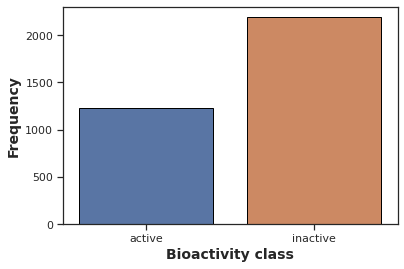

In [28]:
#frequency plot of active/inactive compounds
sns.countplot(x="class", data = df_final_2class, edgecolor = "black")

plt.xlabel("Bioactivity class", fontsize = 14, fontweight = "bold")
plt.ylabel("Frequency", fontsize = 14, fontweight = "bold")
plt.savefig("plot_bioactivity_class.pdf")

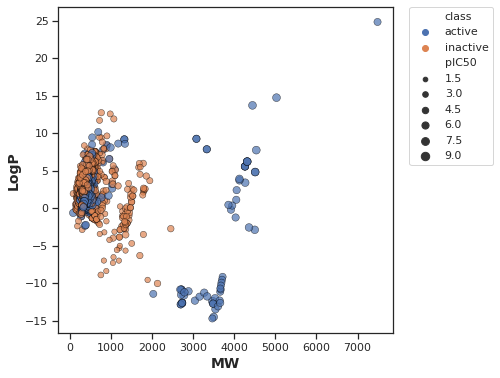

In [29]:
#creating a scatter plot of Molecular Weight vs LogP
plt.figure(figsize=(6, 6))

sns.scatterplot(x="MW", y="LogP", data = df_final_2class, hue = "class", size = "pIC50", edgecolor = "black", alpha = 0.7)

plt.xlabel("MW", fontsize = 14, fontweight = "bold")
plt.ylabel("LogP", fontsize = 14, fontweight = "bold")
plt.legend(bbox_to_anchor = (1.05, 1), loc=2, borderaxespad=0)
plt.savefig("plot_MW_vs_LogP.pdf")

In [30]:
#Mann-Whitney U Test for statistical significance analysis
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_final_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_final_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

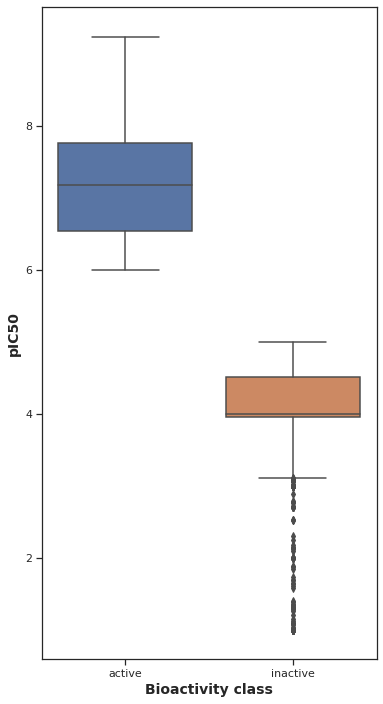

In [31]:
#box plot of active/inactive compounds by pIC50 value
plt.figure(figsize=(6, 12))

sns.boxplot(x="class", y="pIC50", data = df_final_2class,)

plt.xlabel("Bioactivity class", fontsize = 14, fontweight = "bold")
plt.ylabel("pIC50", fontsize = 14, fontweight = "bold")

plt.savefig("pIC50_plot.pdf")

In [32]:
#Mann Whitney test for pIC50
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.0,0.05,Different distribution (reject H0)


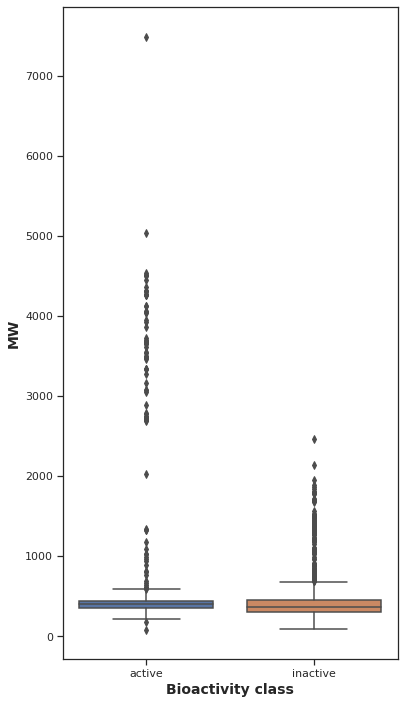

In [33]:
#box plot of active/inactive compounds by MW value
plt.figure(figsize=(6, 12))

sns.boxplot(x="class", y="MW", data = df_final_2class)

plt.xlabel("Bioactivity class", fontsize = 14, fontweight = "bold")
plt.ylabel("MW", fontsize = 14, fontweight = "bold")

plt.savefig("pIC50_plot.pdf")

In [34]:
#Mann Whitney test for pIC50
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1134598.0,9.345892e-15,0.05,Different distribution (reject H0)


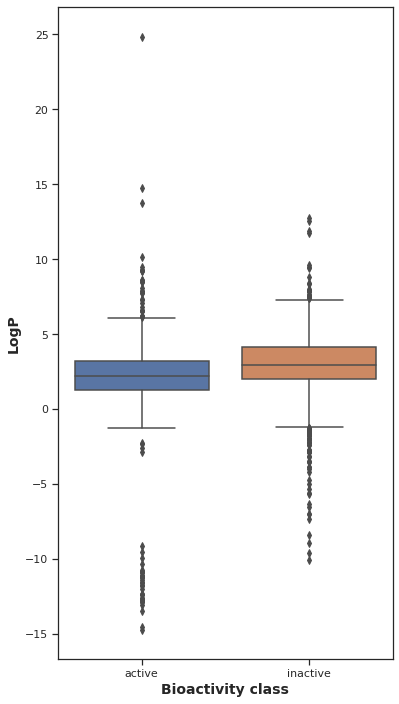

In [35]:
#box plot of active/inactive compounds by LogP value
plt.figure(figsize=(6, 12))

sns.boxplot(x="class", y="LogP", data = df_final_2class)

plt.xlabel("Bioactivity class", fontsize = 14, fontweight = "bold")
plt.ylabel("LogP", fontsize = 14, fontweight = "bold")

plt.savefig("pIC50_plot.pdf")

In [36]:
#Mann Whitney test for pIC50
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,974762.5,2.096051e-41,0.05,Different distribution (reject H0)


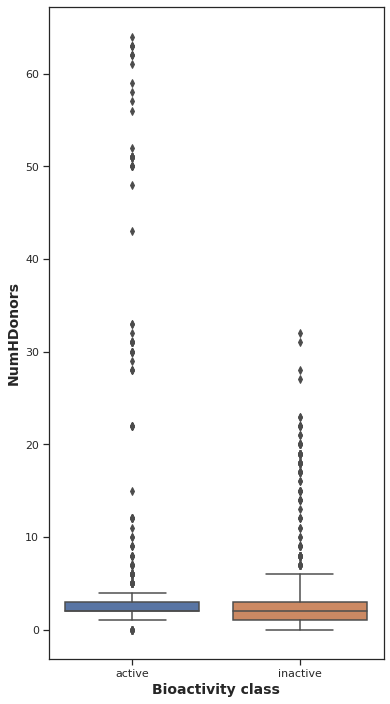

In [37]:
#box plot of active/inactive compounds by Number of Hydrogen donors value
plt.figure(figsize=(6, 12))

sns.boxplot(x="class", y="NumHDonors", data = df_final_2class)

plt.xlabel("Bioactivity class", fontsize = 14, fontweight = "bold")
plt.ylabel("NumHDonors", fontsize = 14, fontweight = "bold")

plt.savefig("pIC50_plot.pdf")

In [38]:
#Mann Whitney test for pIC50
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1214938.0,3.972007e-07,0.05,Different distribution (reject H0)


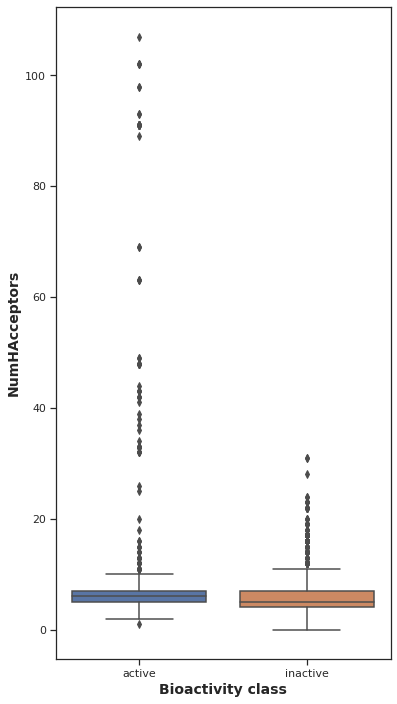

In [39]:
#box plot of active/inactive compounds by Number of Hydrogen acceptors value
plt.figure(figsize=(6, 12))

sns.boxplot(x="class", y="NumHAcceptors", data = df_final_2class)

plt.xlabel("Bioactivity class", fontsize = 14, fontweight = "bold")
plt.ylabel("NumHAcceptors", fontsize = 14, fontweight = "bold")

plt.savefig("pIC50_plot.pdf")

In [40]:
#Mann Whitney test for pIC50
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1124335.0,2.287311e-16,0.05,Different distribution (reject H0)


**Brief summary of the results**

As expected, there is statical significant difference between the pIC50 values of active vs inactive bioactivity classes, due to our choice of thresholds.

All 4 Lipinski's descriptors showed statistically significant difference between actives and inactives.

Although these descriptos give a great macro-overview of the examined drug molecule, better tools are available for calculation of more detailed (micro) descriptors, e.g. PaDEL.


In [41]:
#compressing all the data into a single zip folder
!zip -r data_and_results.zip . -i *.csv *.pfd

updating: bioactivity_data.csv (deflated 93%)
updating: HIV1_integrase_inhibitor_bioactivity_data_preprocessed.csv (deflated 83%)
updating: HIV1_integrase_inhibitor_bioactivity_data_curated.csv (deflated 84%)
updating: HIV1_integrase_inhibitor_3class_pIC50.csv (deflated 79%)
updating: HIV1_integrase_inhibitor_2class_pIC50.csv (deflated 79%)
updating: mannwhitneyu_pIC50.csv (deflated 14%)
updating: mannwhitneyu_MW.csv (deflated 8%)
updating: mannwhitneyu_LogP.csv (deflated 8%)
updating: mannwhitneyu_NumHDonors.csv (deflated 11%)
updating: mannwhitneyu_NumHAcceptors.csv (deflated 11%)
updating: descriptors_output.csv (deflated 96%)
updating: HIV1_integrase_inhibitor_bioactivity_data_3class_pIC50_pubchem_fp_PaDEL.csv (deflated 96%)


# Detailed descriptor calculation and dataset preparation using PaDEL


In [42]:
#downloading PaDEL descriptors
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2022-01-14 11:56:07--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2022-01-14 11:56:07--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip.6’

padel.zip.6         100%[===================>]  24.57M  31.9MB/s    in 0.8s    

2022-01-14 11:56:09 (31.9 MB/s) - ‘padel.zip.6’ saved [25768637/25768637]

--2022-01-14 11:56:09--  https

In [43]:
#extracting PaDEL descriptors
#! unzip padel.zip

In [44]:
#preparing the dataset for descriptor calculation using 3 class dataset
df_3c = df_final
selection = ["canonical_smiles", "molecule_chembl_id"]
df_selection = df_3c[selection]
df_selection.to_csv("molecule.smi", sep = "\t", index = False, header = False)

In [45]:
#checking the formatting of the dataset
! cat molecule.smi | head -5

O=C(/C=C/c1ccc(O)c(O)c1)O[C@H](Cc1ccc(O)c(O)c1)C(=O)O	CHEMBL324842
O=C(CC(O)CCc1ccc(O)c(O)c1)O[C@H]1Cc2cc(O)c(O)cc2O[C@H]1c1ccc(O)c(O)c1	CHEMBL304722
O=C(CCc1ccc(O)c(O)c1)c1ccc(O)c(O)c1O	CHEMBL67076
O=C(/C=C/c1ccc(O)c(O)c1)O[C@H]1[C@H](O)C[C@](O)(C(=O)O)C[C@H]1OC(=O)/C=C/c1ccc(O)c(O)c1	CHEMBL177126
O=C(O)C(=O)CC(=O)c1cccc(Cc2cccc(Cl)c2)c1	CHEMBL145335


In [46]:
#checking number of molecules in dataset
! cat molecule.smi | wc -l

4072


In [47]:
#description of padel function
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [48]:
##calculating PaDEL descriptors
#! bash padel.sh

In [49]:
#taking a look at the PaDEL output
df_3c_X = pd.read_csv("descriptors_output.csv")
df_3c_X 

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL324842,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL67076,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL304722,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL145335,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL177126,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4067,CHEMBL4649015,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4068,CHEMBL4640673,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4069,CHEMBL4633363,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4070,CHEMBL4644631,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
#removing redundant name column
df_3c_X = df_3c_X.drop(columns=['Name'])
df_3c_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4067,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4068,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4069,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4070,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
#concatenating the pIC50 column with PaDEL descriptors
df3_Y = df_final["pIC50"]
dataset3 = pd.concat([df_3c_X,df3_Y], axis = 1)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.045757
1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.853872
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.769551
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.602060
4,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4067,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.408935
4068,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.677781
4069,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.823909
4070,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.154902


In [52]:
#saving the prepared descriptors dataset
dataset3.to_csv("HIV1_integrase_inhibitor_bioactivity_data_3class_pIC50_pubchem_fp_PaDEL.csv", index=False)

# Model Building

In [53]:
#importing modelling libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold

In [54]:
#rename the feature and label datasets 
X = df_3c_X
Y = df3_Y

In [55]:
#examining the data dimensions of the features dataframe
X.shape

(4072, 881)

In [56]:
#examining the data dimensions of the labels dataframe
Y.shape

(4072,)

In [57]:
#removing low variance features
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [58]:
#examining the data dimensions of the high variance features dataframe
X.shape

(4072, 184)

In [59]:
#splitting the data into 80/20 proportion for training and testing respectively
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2)

In [60]:
#examining the data dimensions of the training datasets
X_train.shape, Y_train.shape

((3257, 184), (3257,))

In [61]:
#examining the data dimensions of the testing datasets
X_test.shape, Y_test.shape

((815, 184), (815,))

In [62]:
#building a regression model using Random Forest
RFR = RandomForestRegressor(n_estimators=100)
RFR.fit(X_train, Y_train)
r2 = RFR.score(X_test, Y_test)
r2

0.5676910437388634

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

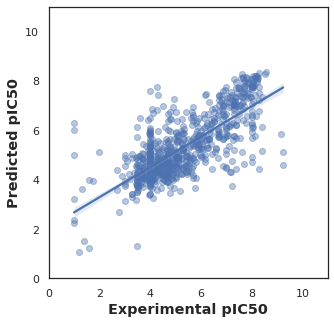

In [63]:
#scatter plot of predicted vs actual (experimental) pIC50 values
Y_pred = RFR.predict(X_test)

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 11)
ax.set_ylim(0, 11)
ax.figure.set_size_inches(5, 5)
plt.show

# Comparing performance of different regressors

In [66]:
#importing more regressors
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from time import time
from matplotlib.pyplot import subplots, axes, bar, xticks
from random import seed

RANDOM_STATE = 123 
seed(RANDOM_STATE)

classifiers = {
'Random Forest': RandomForestRegressor(random_state=RANDOM_STATE),
'AdaBoost (Random Forest)': AdaBoostRegressor(RandomForestRegressor(random_state=RANDOM_STATE)),
'Extra Trees': ExtraTreesRegressor(random_state=RANDOM_STATE),
'AdaBoost (Extra Tree)': AdaBoostRegressor(ExtraTreesRegressor(random_state=RANDOM_STATE)),
'Decision Tree': DecisionTreeRegressor(random_state=RANDOM_STATE),
'SVC (RBF)': SVR(),
'SVC (Linear)': LinearSVR(random_state=RANDOM_STATE),
'Multi-layer Perceptron': MLPRegressor(max_iter=5000,random_state=RANDOM_STATE)
}


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


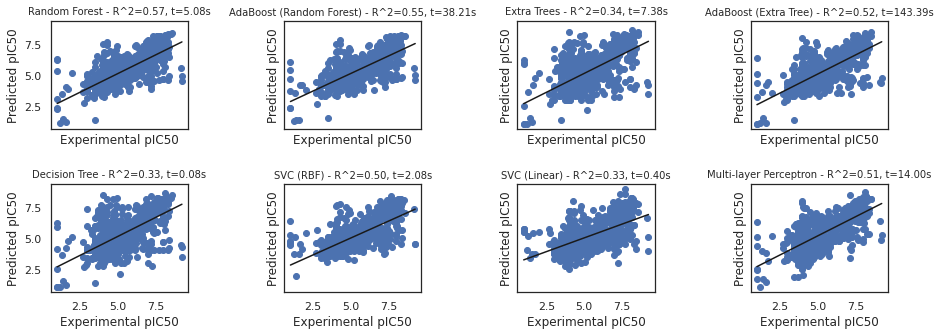

In [69]:
#scoring the selected regressors
fig, all_axes = subplots(figsize=[15, 5], ncols=4, nrows=2, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.7, hspace=0.5)

#for-loop to train the models, make predictions on test data, plot predicted vs. experimental pIC50 values, calculate scores, and calculate time taken for computation.
for ax, (name, clf) in zip(all_axes.ravel(), classifiers.items()):
  start = time()
  clf.fit(X_train, Y_train)
  Y_pred = clf.predict(X_test)
  y_ft_min, y_ft_max = Y_pred.min()*0.8, Y_pred.max()*1.2
  score = clf.score(X_test, Y_test)
  end = time()
  time_taken = end-start
  ax.scatter(Y_test, Y_pred)
  ax.plot(np.unique(Y_test), np.poly1d(np.polyfit(Y_test, Y_pred, 1))(np.unique(Y_test)), color = "k")
  label = '{} - R^2={:.2f}, t={:.2f}s'.format(name, score, time_taken)
  ax.set_title(label , fontsize=10);
  ax.set_xlabel("Experimental pIC50") 
  ax.set_ylabel("Predicted pIC50") 


# Conclusions

Out of the 8 models tested, Random Forest, AdaBoost (Random Forest), AdaBoost (Extra Tree), SVC (RBF), and Multi-layer Perception algorithms performed well, with R^2 value >= 0.5. Random forest had the highest score and the 2nd lowest time taken to compute out of the well-performing algorithms, making it arguably the most optimal model for this task as judged by these criteria. 